In [31]:
# Useful starting lines
%timeit
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
from preprocessing import *
from train_tune import *
from proj1_helpers import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Loading data**

In [30]:
DATA_TRAIN_PATH = '../data/train.csv'
y, tx_train, ids = load_csv_data(DATA_TRAIN_PATH)
#Clustering
tx0, y0, tx1, y1, tx2, y2, tx3, y3 = prijetnum_clustering(tx_train,y)
#histogram_clusters(tx0,tx1,tx2,tx3)

Prediction targets detected. Using a training set. 
 Returning clusterized dataset and targets. 



##### **Pre-processing :: # NEED TO WRITE A PRE-PROCESSING FUNC**



In [26]:
#NEED TO WRITE A PRE-PROCESSING FUNC
names= get_feature_names(DATA_TRAIN_PATH)
#Deleting useless feature: 
tx_df0, idx_tk0 = delete_features(tx0)
tx_df1, idx_tk1 = delete_features(tx1)
tx_df2, idx_tk2 = delete_features(tx2)
tx_df3, idx_tk3 = delete_features(tx3)

#Replacing remaining -999 values with the median of that feature
tx_df0 = replace_999_median(tx_df0)
tx_df1 = replace_999_median(tx_df1)
tx_df2 = replace_999_median(tx_df2)
tx_df3 = replace_999_median(tx_df3)

tx_meandf0 = replace_999_mean(tx_df0)
tx_meandf1 = replace_999_mean(tx_df1)
tx_meandf2 = replace_999_mean(tx_df2)
tx_meandf3 = replace_999_mean(tx_df3)
#std+adding bias
tx_df0, _, _ = standardize(tx_df0)
tx_df1, _, _ = standardize(tx_df1)
tx_df2, _, _ = standardize(tx_df2)
tx_df3, _, _ = standardize(tx_df3)

tx_meandf0, _, _ = standardize(tx_meandf0)
tx_meandf1, _, _ = standardize(tx_meandf1)
tx_meandf2, _, _ = standardize(tx_meandf2)
tx_meandf3, _, _ = standardize(tx_meandf3)
#NO NEED TO ADD BIAS because we use build_poly in cv_gridsearch
#tx_df0 = add_bias(tx_df0)
#tx_df1 = add_bias(tx_df1)
#tx_df2 = add_bias(tx_df2)
#tx_df3 = add_bias(tx_df3)
print("Removed features for cluster 0 :",idx_tk0," \n",(names[idx_tk0]))
print("Removed features for cluster 1 :",idx_tk1," \n",(names[idx_tk1]))


10 features deleted
7 features deleted
0 features deleted
0 features deleted
Removed features for cluster 0 : [4, 5, 6, 12, 23, 24, 25, 26, 27, 28]  
 ['DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_lep_eta_centrality' 'PRI_jet_leading_pt' 'PRI_jet_leading_eta'
 'PRI_jet_leading_phi' 'PRI_jet_subleading_pt' 'PRI_jet_subleading_eta'
 'PRI_jet_subleading_phi']
Removed features for cluster 1 : [4, 5, 6, 12, 26, 27, 28]  
 ['DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_lep_eta_centrality' 'PRI_jet_subleading_pt' 'PRI_jet_subleading_eta'
 'PRI_jet_subleading_phi']


### **K-fold Cross-validation to find the best lambdas, degrees, features to remove, etc**

See `traintune.py`. Given the size of each cluster within the train set, I advice clustering before K-fold splitting to maximize the amount of datapoints in each cluster-group.

def crossval_ridge_gridsearch(y, tx_clust, k_fold, lambdas, degrees, loss=False):
    """
    Input : y (target), np.array
            tx (dataset), np.array
            k_fold, int 
            lambdas, degrees : np.arrays containing the values to be tested.
            loss, bool : If true, will return the train-test loss arrays, to be used in viz for plotting.
            
    Returns the lambda, degree and associated weight that optimizes
    the RMSE loss for Ridge Regression using K-fold cross validation.
    It is advisable to use clusterized and pre-processed tx as input 
    in order to maximize data points in each of the cluster/k'th subgroup.
    
    Computes the best degree of polynomial expansion and its associated
    optimal value of lambda.
    """
    #Initializing values. 
    k_indices = build_k_indices(y, k_fold)
    #Get arrays of train and test loss for each degree (in axis=0), and each lambdas(in axis=1)
    total_train_loss = np.empty((len(degrees),len(lambdas)))
    total_test_loss = np.empty((len(degrees),len(lambdas)))
    #Gridsearch loops.
    for id_deg, degree in enumerate(degrees):
        print("Iterating. Testing {} lambdas for current degree = {}".format(len(lambdas),degree))
        lambda_train_loss = []
        lambda_test_loss = []
        
        for id_lam, lambda_ in enumerate(lambdas):
            train_loss_tmp = []
            test_loss_tmp = []
            
            for k in range(k_fold):
                train_loss, test_loss, w = cross_validation_result(y,tx_clust,
                                                                   k_indices,
                                                                   k,lambda_,degree)
                train_loss_tmp.append(train_loss)
                test_loss_tmp.append(test_loss)
            print("Train{},test {}".format(np.mean(train_loss_tmp),np.mean(test_loss_tmp)))
            lambda_train_loss.append(np.mean(train_loss_tmp))
            lambda_test_loss.append(np.mean(test_loss_tmp))
            
        total_train_loss[id_deg,:]=lambda_train_loss
        total_test_loss[id_deg,:]=lambda_test_loss
        
    #Getting the best degree, values.
    print("Getting best degree and lambda")
    best_id = np.argwhere(total_test_loss==np.min(total_test_loss))[0,]
    best_degree = degrees[best_id[0]]
    best_lambda = lambdas[best_id[1]]
    
    #Getting the optimized weights.
    print("Ridge regression : getting optimal weights with best degree ({}), lambda ({})".format(best_degree,
                                                                                                best_lambda))
    tx_poly = build_poly(tx_clust,best_degree)
    w_opt = ridge_regression(y,tx_clust,best_lambda)
    if loss==False:
        print("wtf")
        return w_opt, best_degree, best_lambda
    elif loss:
        print("Returning train and test loss arrays for visualization")
        return w_opt, best_degree, best_lambda, total_train_loss, total_test_loss
    
    

In [14]:
degrees = range(4)
total_train_loss = np.empty((len(degrees),len(lambdas)))
for id_deg, degree in enumerate(degrees):
    lambda_train_loss = []
    print("beginning loop train loss",lambda_train_loss)
    for id_lam, lambda_ in enumerate(lambdas):
        train_loss_tmp = []
        
        for k in range(k_fold):
            
            train_loss_tmp.append(k)
        lambda_train_loss.append(np.mean(train_loss_tmp))
    print("lambda train loss after lambda loop", lambda_train_loss)
    total_train_loss[id_deg,:]=lambda_train_loss
print(total_train_loss)

beginning loop train loss []
lambda train loss after lambda loop [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
beginning loop train loss []
lambda train loss after lambda loop [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
beginning loop train loss []
lambda train loss after lambda loop [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
beginning loop train loss []
lambda train loss after lambda loop [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[[2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2.]]


In [4]:
def cv_viz(degree,lambds, mse_tr, mse_te):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("Cross validation : Degree={}".format(degree))
    plt.legend(loc=2)
    plt.grid(True)
    #plt.savefig("cross_validation")


In [5]:
k_fold=10
lambdas = np.logspace(-8,-1,12)
degrees = np.array(range(1,12))

**sanity check**

In [56]:
for deg in degrees:
    print("current deg iteration",deg)
    t=build_poly(tx_df0,deg)
    print(t.shape)

current deg iteration 1
(99913, 22)
current deg iteration 2
(99913, 43)
current deg iteration 3
(99913, 64)
current deg iteration 4
(99913, 85)


Something's wrong. When printing, we see that one of the k'th group systematically has very high test error compared to the others when augmenting the features to degrees above 1. What is wrong?

Iterating. Testing 12 lambdas for current degree = 1
Iterating. Testing 12 lambdas for current degree = 2
Iterating. Testing 12 lambdas for current degree = 3
Iterating. Testing 12 lambdas for current degree = 4
Iterating. Testing 12 lambdas for current degree = 5
Iterating. Testing 12 lambdas for current degree = 6
Iterating. Testing 12 lambdas for current degree = 7
Iterating. Testing 12 lambdas for current degree = 8
Iterating. Testing 12 lambdas for current degree = 9
Iterating. Testing 12 lambdas for current degree = 10
Iterating. Testing 12 lambdas for current degree = 11
Iterating. Testing 12 lambdas for current degree = 12
Getting best degree and lambda
Ridge regression : getting optimal weights with best degree (1), lambda (1.873817422860383e-07)
Returning train and test loss arrays for visualization
0.6963157090133777


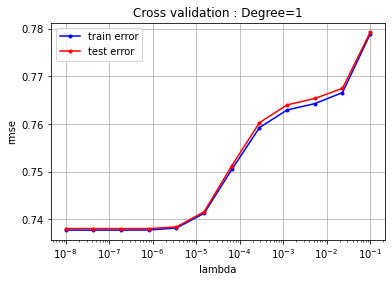

In [98]:
w, deg, lam, trainloss,testloss= crossval_ridge_gridsearch(y0,tx_df0, k_fold, 
                                                          lambdas, degrees,loss=True)
cv_viz(deg,lambdas,trainloss[deg-1,:],testloss[deg-1,:])
print(np.amin(trainloss))

Iterating. Testing 12 lambdas for current degree = 1
Iterating. Testing 12 lambdas for current degree = 2
Iterating. Testing 12 lambdas for current degree = 3
Iterating. Testing 12 lambdas for current degree = 4
Iterating. Testing 12 lambdas for current degree = 5
Iterating. Testing 12 lambdas for current degree = 6
Iterating. Testing 12 lambdas for current degree = 7
Iterating. Testing 12 lambdas for current degree = 8
Iterating. Testing 12 lambdas for current degree = 9
Iterating. Testing 12 lambdas for current degree = 10
Iterating. Testing 12 lambdas for current degree = 11
Iterating. Testing 12 lambdas for current degree = 12
Getting best degree and lambda
Ridge regression : getting optimal weights with best degree (5), lambda (1.873817422860383e-07)
Returning train and test loss arrays for visualization
50 0.8077414765059748


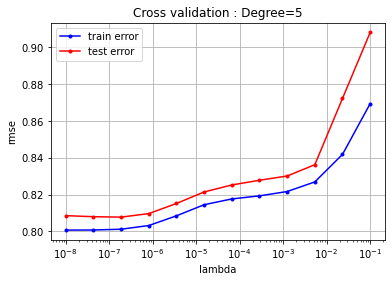

In [99]:
w1, deg1, lam1, trainloss1, testloss1 = crossval_ridge_gridsearch(y1,tx_df1, 
                                                                  k_fold, lambdas,
                                                                  degrees,loss=True)
cv_viz(deg1,lambdas,trainloss1[deg1-1,:],testloss1[deg1-1,:])
print(np.argmin(testloss1),np.amin(testloss1))

**sanity check**

In [ ]:
#SANITY CHECK
best_id = np.argwhere(testloss1==np.min(testloss1))
test = np.min(testloss1)
print(test)
print(best_id)
print("best degree",degrees[best_id[0,0]])
print("best lambda",lambdas[best_id[0,1]],"bestid",best_id[0,1])
print("losst2", testloss2[best_id[0,0],best_id[0,1]])

Iterating. Testing 12 lambdas for current degree = 1
Iterating. Testing 12 lambdas for current degree = 2
Iterating. Testing 12 lambdas for current degree = 3
Iterating. Testing 12 lambdas for current degree = 4
Iterating. Testing 12 lambdas for current degree = 5
Iterating. Testing 12 lambdas for current degree = 6
Iterating. Testing 12 lambdas for current degree = 7
Iterating. Testing 12 lambdas for current degree = 8
Iterating. Testing 12 lambdas for current degree = 9
Iterating. Testing 12 lambdas for current degree = 10
Iterating. Testing 12 lambdas for current degree = 11
Iterating. Testing 12 lambdas for current degree = 12
Getting best degree and lambda
Ridge regression : getting optimal weights with best degree (5), lambda (1.5199110829529332e-05)
Returning train and test loss arrays for visualization


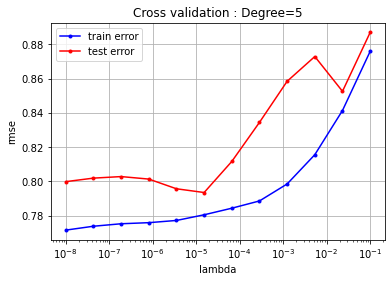

In [100]:
w2, deg2, lam2, trainloss2, testloss2 = crossval_ridge_gridsearch(y2,tx_df2, 
                                                                  k_fold, lambdas,
                                                                  degrees,loss=True)
cv_viz(deg2,lambdas,trainloss2[deg2-1,:],testloss2[deg2-1,:])

Iterating. Testing 12 lambdas for current degree = 1
Iterating. Testing 12 lambdas for current degree = 2
Iterating. Testing 12 lambdas for current degree = 3
Iterating. Testing 12 lambdas for current degree = 4
Iterating. Testing 12 lambdas for current degree = 5
Iterating. Testing 12 lambdas for current degree = 6
Iterating. Testing 12 lambdas for current degree = 7
Iterating. Testing 12 lambdas for current degree = 8
Iterating. Testing 12 lambdas for current degree = 9
Iterating. Testing 12 lambdas for current degree = 10
Iterating. Testing 12 lambdas for current degree = 11
Iterating. Testing 12 lambdas for current degree = 12
Getting best degree and lambda
Ridge regression : getting optimal weights with best degree (4), lambda (1e-08)
Returning train and test loss arrays for visualization
36 0.7980789343006914


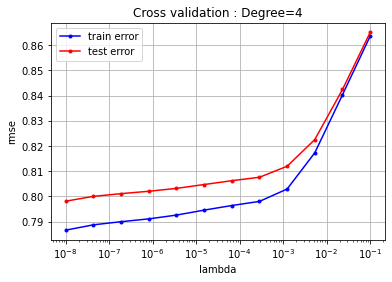

In [101]:
w3, deg3, lam3, trainloss3, testloss3 = crossval_ridge_gridsearch(y3,tx_df3, 
                                                                  k_fold, lambdas,
                                                                  degrees,loss=True)
cv_viz(deg3,lambdas,trainloss3[deg3-1,:],testloss3[deg3-1,:])
print(np.argmin(testloss3),np.amin(testloss3))

## Generate predictions and save ouput in csv format for submission:

In [15]:
k_fold=10
lambdas = np.logspace(-9,-1,12)
degrees = np.array(range(1,8))

In [27]:
wopt0m, deg0m, _ = crossval_ridge_gridsearch(y0,tx_meandf0,k_fold,lambdas,degrees,loss=False)
wopt1m, deg1m, _ = crossval_ridge_gridsearch(y1,tx_meandf1,k_fold,lambdas,degrees,loss=False)
wopt2m, deg2m, _ = crossval_ridge_gridsearch(y2,tx_meandf2,k_fold,lambdas,degrees,loss=False)
wopt3m, deg3m, _ = crossval_ridge_gridsearch(y3,tx_meandf3,k_fold,lambdas,degrees,loss=False)

Iterating. Testing 12 lambdas for current degree = 1
Iterating. Testing 12 lambdas for current degree = 2
Iterating. Testing 12 lambdas for current degree = 3
Iterating. Testing 12 lambdas for current degree = 4
Iterating. Testing 12 lambdas for current degree = 5
Iterating. Testing 12 lambdas for current degree = 6
Iterating. Testing 12 lambdas for current degree = 7
Getting best degree and lambda
Ridge regression : getting optimal weights with best degree (1), lambda (8.111308307896872e-07)
Iterating. Testing 12 lambdas for current degree = 1
Iterating. Testing 12 lambdas for current degree = 2
Iterating. Testing 12 lambdas for current degree = 3
Iterating. Testing 12 lambdas for current degree = 4
Iterating. Testing 12 lambdas for current degree = 5
Iterating. Testing 12 lambdas for current degree = 6
Iterating. Testing 12 lambdas for current degree = 7
Getting best degree and lambda
Ridge regression : getting optimal weights with best degree (5), lambda (1.519911082952933e-07)
Iter

In [16]:
wopt0, deg0, _ = crossval_ridge_gridsearch(y0,tx_df0,k_fold,lambdas,degrees,loss=False)
wopt1, deg1, _ = crossval_ridge_gridsearch(y1,tx_df1,k_fold,lambdas,degrees,loss=False)
wopt2, deg2, _ = crossval_ridge_gridsearch(y2,tx_df2,k_fold,lambdas,degrees,loss=False)
wopt3, deg3, _ = crossval_ridge_gridsearch(y3,tx_df3,k_fold,lambdas,degrees,loss=False)


Iterating. Testing 12 lambdas for current degree = 1
Iterating. Testing 12 lambdas for current degree = 2
Iterating. Testing 12 lambdas for current degree = 3
Iterating. Testing 12 lambdas for current degree = 4
Iterating. Testing 12 lambdas for current degree = 5
Iterating. Testing 12 lambdas for current degree = 6
Iterating. Testing 12 lambdas for current degree = 7
Getting best degree and lambda
Ridge regression : getting optimal weights with best degree (1), lambda (8.111308307896872e-07)
Iterating. Testing 12 lambdas for current degree = 1
Iterating. Testing 12 lambdas for current degree = 2
Iterating. Testing 12 lambdas for current degree = 3
Iterating. Testing 12 lambdas for current degree = 4
Iterating. Testing 12 lambdas for current degree = 5
Iterating. Testing 12 lambdas for current degree = 6
Iterating. Testing 12 lambdas for current degree = 7
Getting best degree and lambda
Ridge regression : getting optimal weights with best degree (5), lambda (1.519911082952933e-07)
Iter

In [17]:
#Getting test-data
DATA_TEST_PATH = '../data/test.csv' # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
OUTPUT_PATH = '../submissions/' # TODO: fill in desired name of output file for submission   

In [28]:
#Clustering
test0, i0, test1, i1, test2, i2, test3, i3, = prijetnum_clustering(tX_test)
print(test0.shape)
#Deleting useless feature using the indices : 
test0 = np.delete(test0,idx_tk0,1)
test1 = np.delete(test1,idx_tk1,1) 
test2 = np.delete(test2,idx_tk2,1) 
test3 = np.delete(test3,idx_tk3,1) 

#Replacing remaining -999 values with the median of that feature
test0 = replace_999_median(test0)
test1 = replace_999_median(test1)
test2 = replace_999_median(test2)
test3 = replace_999_median(test3)

test0m = replace_999_mean(test0)
test1m = replace_999_mean(test1)
test2m = replace_999_mean(test2)
test3m = replace_999_mean(test3)

#Preprocessing + Bias
test0, _, _ = standardize(test0)
test1, _, _ = standardize(test1)
test2, _, _ = standardize(test2)
test3, _, _ = standardize(test3)
#Preprocessing + Bias
test0m, _, _ = standardize(test0m)
test1m, _, _ = standardize(test1m)
test2m, _, _ = standardize(test2m)
test3m, _, _ = standardize(test3m)

#This achieves the same as adds a bias + build the deg
test0 = build_poly(test0,deg0)
test1 = build_poly(test1,deg1)
test2 = build_poly(test2,deg2)
test3 = build_poly(test3,deg3)

#This achieves the same as adds a bias + build the deg
test0m = build_poly(test0m,deg0m)
test1m = build_poly(test1m,deg1m)
test2m = build_poly(test2m,deg2m)
test3m = build_poly(test3m,deg3m)


No targets detected. Using a test-set. 
 Returning clusterized dataset and indices. 

(227458, 30)
(227458, 20)


*shape check*

In [22]:
print("cluster0",wopt0.shape,test0.shape)
print("cluster0",wopt1.shape,test1.shape)
print("cluster0",wopt2.shape,test2.shape)
print("cluster0",wopt3.shape,test3.shape)

cluster0 (21,) (227458, 21)
cluster0 (116,) (175338, 116)
cluster0 (91,) (114648, 91)
cluster0 (121,) (50794, 121)


In [29]:
#ridge prediction
ypredridge_0 = predict_labels(wopt0,test0)
ypredridge_1 = predict_labels(wopt1,test1)
ypredridge_2 = predict_labels(wopt2,test2)
ypredridge_3 = predict_labels(wopt3,test3)

ypredridge_0m = predict_labels(wopt0m,test0m)
ypredridge_1m = predict_labels(wopt1m,test1m)
ypredridge_2m = predict_labels(wopt2m,test2m)
ypredridge_3m = predict_labels(wopt3m,test3m)

ypred_ridge = np.ones(ids_test.shape[0])
ypred_ridge[i0]=ypredridge_0
ypred_ridge[i1]=ypredridge_1
ypred_ridge[i2]=ypredridge_2
ypred_ridge[i3]=ypredridge_3

ypred_ridgem = np.ones(ids_test.shape[0])
ypred_ridgem[i0]=ypredridge_0m
ypred_ridgem[i1]=ypredridge_1m
ypred_ridgem[i2]=ypredridge_2m
ypred_ridgem[i3]=ypredridge_3m

create_csv_submission(ids_test, ypred_ridge, OUTPUT_PATH+"CV_cluster_ridge_999med.csv")
create_csv_submission(ids_test, ypred_ridgem, OUTPUT_PATH+"CV_cluster_ridge_999mean.csv")

In [71]:
#Log prediction
ypred_log0 = predict_labels_log(wlog_opt0,test0)
ypred_log1 = predict_labels_log(wlog_opt1,test1)
ypred_log2 = predict_labels_log(wlog_opt2,test2)
ypred_log3 = predict_labels_log(wlog_opt3,test3)

ypred_log = np.ones(ids_test.shape[0])
ypred_log[i0]=ypred_log0
ypred_log[i1]=ypred_log1
ypred_log[i2]=ypred_log2
ypred_log[i3]=ypred_log3
                   
create_csv_submission(ids_test, ypred_log, OUTPUT_PATH+"reguLogCluster.csv")
create_csv_submission(ids_test, ypred_log, OUTPUT_PATH+"reguLogCluster.csv")